# Import networks

In [1]:
import networkx as nx
SNet = nx.read_gml("data/graphs/snet.gml")
SNetF = nx.read_gml("data/graphs/snetf.gml")
SNetT = nx.read_gml("data/graphs/snett.gml")
UserNet = nx.read_gml("data/graphs/usernet.gml")

In [2]:
print(nx.info(SNet))
print(nx.info(SNetF))
print(nx.info(SNetT))
print(nx.info(UserNet))

Name: 
Type: Graph
Number of nodes: 4191
Number of edges: 135974
Average degree:  64.8886
Name: 
Type: Graph
Number of nodes: 4191
Number of edges: 6113
Average degree:   2.9172
Name: 
Type: Graph
Number of nodes: 39
Number of edges: 741
Average degree:  38.0000
Name: 
Type: DiGraph
Number of nodes: 18975
Number of edges: 102043
Average in degree:   5.3778
Average out degree:   5.3778


# Community detection

## 20 If the network size allows, use spectral analysis or dendrogram analysis to compute the potential candidates for the number of communities


spectral - gehpi modularity-reports

> Dendrogram creation: https://stackoverflow.com/questions/59821151/plot-the-dendrogram-of-communities-found-by-networkx-girvan-newman-algorithm

In [3]:
import networkx as nx
from itertools import chain, combinations
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# https://stackoverflow.com/questions/59821151/plot-the-dendrogram-of-communities-found-by-networkx-girvan-newman-algorithm
def draw_dendogram(graph_name, G):
    # get simulated Graph() and Girvan-Newman communities list
    communities = list(nx.community.girvan_newman(G))

    # building initial dict of node_id to each possible subset:
    node_id = 0
    init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
    for comm in communities:
        for subset in list(comm):
            if subset not in init_node2community_dict.values():
                node_id += 1
                init_node2community_dict[node_id] = subset

    # turning this dictionary to the desired format in @mdml's answer
    node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
    for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
        for node_id_parent, group in init_node2community_dict.items():
            if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
                node_id_to_children[node_id_parent].append(node_id1)
                node_id_to_children[node_id_parent].append(node_id2)

    # also recording node_labels dict for the correct label for dendrogram leaves
    node_labels = dict()
    for node_id, group in init_node2community_dict.items():
        if len(group) == 1:
            node_labels[node_id] = list(group)[0]
        else:
            node_labels[node_id] = ''

    # also needing a subset to rank dict to later know within all k-length merges which came first
    subset_rank_dict = dict()
    rank = 0
    for e in communities[::-1]:
        for p in list(e):
            if tuple(p) not in subset_rank_dict:
                subset_rank_dict[tuple(sorted(p))] = rank
                rank += 1
    subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank

    # my function to get a merge height so that it is unique (probably not that efficient)
    def get_merge_height(sub):
        sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
        n = len(sub_tuple)
        other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
        min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
        range = (max_rank-min_rank) if max_rank > min_rank else 1
        return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range

    # finally using @mdml's magic, slightly modified:
    G           = nx.DiGraph(node_id_to_children)
    nodes       = G.nodes()
    leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
    inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]

    # Compute the size of each subtree
    subtree = dict( (n, [n]) for n in leaves )
    for u in inner_nodes:
        children = set()
        node_list = list(node_id_to_children[u])
        while len(node_list) > 0:
            v = node_list.pop(0)
            children.add( v )
            node_list += node_id_to_children[v]
        subtree[u] = sorted(children & leaves)

    inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

    # Construct the linkage matrix
    leaves = sorted(leaves)
    index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
    Z = []
    k = len(leaves)
    for i, n in enumerate(inner_nodes):
        children = node_id_to_children[n]
        x = children[0]
        for y in children[1:]:
            z = tuple(sorted(subtree[x] + subtree[y]))
            i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
            Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
            index[z] = k
            subtree[z] = list(z)
            x = z
            k += 1

    # dendrogram
    plt.figure(figsize=(16,8), dpi=80)
    dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves])
    plt.savefig(f"data/gephi/{graph_name}/modularity-report/dendrogram.png")

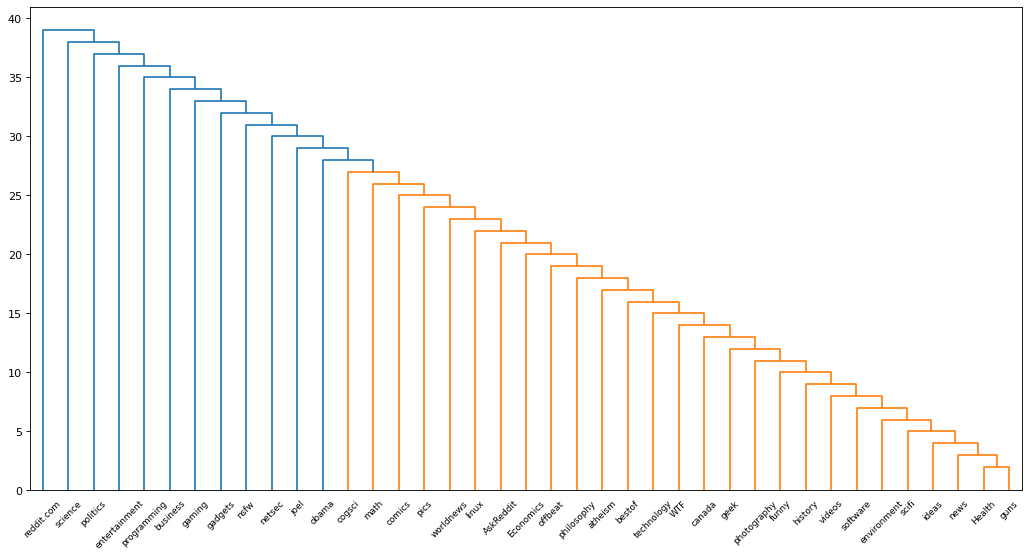

In [4]:
draw_dendogram("SNetT", SNetT)

In [5]:
# cannot finish
# draw_dendogram("SNet", SNet)

In [6]:
# cannot finish
# draw_dendogram("SNetF", SNetF) 

In [7]:
# cannot finish
# draw_dendogram("UserNet", UserNet)

## 21 Using the *Louvain* method (modularity maximization), use 3 different resolution values and discuss the differences. Visualize and discuss how the chosen values affect the clustering (number and sizes of clusters). 


Per Gephi:

    * For R < 1.0 : More communities
    * For R > 1.0 : Less communities
    
I will be using just the SNet Network since the community behaviour will be the same

    1. Resoltion = 5
        Number of communities: 799
    
    2. Resolution = 10
        Number of communities: 799
       
    3. Resolution = 2.5
        Number of communities: 809
    
    4. Resolution = 0.5
        Number of communities: 824
    
    5. Resolution = 0.25
        Number of communities: 858

## 22 Whcih communities can be seen while analyzing the networks? Is there an explanation for their detection? 

    1.SNet:
    
           - No specific rule of partitioning
    
    2.SNetF:
          - No specific communities, the more pronounced (higher degree) should say that they are of more importance, but we can see both 'WTF', 'entertainment', 'funny', as well as 'politics', 'programming', 'business' in the bigger (blue) community, and in the other 'obama', 'economics', 'askreddit', 'linux' etc. The division doesn't seem to be topic related, but there could be other characteristics at hand (what comes to mind is USA vs Europe, Passive vs Active (where you would submit more than comment) etc. I cannot determine anything from this graph.
          
    3.SNetT:
            - As it is a complete graph, there are no communities. Each and every node is connected to all other.
            
    4.UserNet:
            - Too big to deduct anything.

## 23 Who are the brokers and why are they the brockers? (Bridging)

* High betweenness centrality
* Brokerage
* Low network contraints

In [8]:
print("Which networks have brokers: ")
print(f"SNet: {nx.has_bridges(SNet)}")
print(f"SNet: {nx.has_bridges(SNetF)}")
print(f"SNet: {nx.has_bridges(SNetT)}")
print(f"SNet: Maybe -> directed graphs cannot be tested for bridging in networkx")

Which networks have brokers: 
SNet: True
SNet: True
SNet: False
SNet: Maybe -> directed graphs cannot be tested for bridging in networkx


Is it enough to just take the nodes with the most bridges and remove them?

In [9]:
import pandas as pd

def get_all_bridges(graph):
    df1 = pd.DataFrame(list(nx.bridges(graph)), columns=["subredditSrc", "subredditDst"])
    df2 = pd.DataFrame(list(nx.bridges(graph)), columns=["subredditDst", "subredditSrc"])
    df = pd.merge(df1, df2, on="subredditSrc", how="outer").groupby("subredditSrc").size().reset_index(name="counts")
    df = df.sort_values(by="counts", ascending=False)
    return df

In [10]:
get_all_bridges(SNet).iloc[:10]

,subredditSrc,counts
539,reddit.com,355
357,business,20
528,programming,16
51,Chinese,13
580,technology,9
524,politics,9
402,entertainment,8
521,pics,7
610,worldnews,7
423,funny,5


There is no centrality involved.

Let's try to create some brokerage ranks.
Since we need high betweenness centrality and low network constraints:

$$ brokerage = \frac{BC}{NC} $$

In [90]:
from numpy import ones

def create_brokerage_dataframe(graph):
    print("Creating...")
    # chosen 1 as it will not change the relation between the BC and brokerage
    nc = nx.constraint(graph, weight="weight") if graph.number_of_edges() < 100000 else dict([(node, 1.0) for node in graph])
    bc = nx.betweenness_centrality(graph, weight="weight")
    brokerage = [a / b for a, b in zip(bc.values(), nc.values())]
    df = pd.DataFrame(graph.nodes(), columns=['subreddit'])
    df["brokerage"] = brokerage
    df["BC"] = bc.values()
    df["NC"] = nc.values()
    return df.sort_values("brokerage", ascending=False)

In [117]:
import pickle 

def save_brokerage(brokerage_name, brokerage):
    pickle.dump(brokerage, open(f"data/brokerages/{brokerage_name}", "wb"))

def get_or_create_brokerage(graph, graph_name):
    try:
        return pickle.load(open(f"data/brokerages/{graph_name.lower()}_brokerage", "rb"))
    except (OSError, IOError) as e:
        df = create_brokerage_dataframe(graph)
        save_brokerage(f"{graph_name.lower()}_brokerage", df)
        return df

In [119]:
get_or_create_brokerage(SNet, "SNet").iloc[:10]

,subreddit,brokerage,BC,NC
0,reddit.com,0.217789,0.217789,1.0
90,technology,0.026349,0.026349,1.0
7,programming,0.025797,0.025797,1.0
8,business,0.025280,0.025280,1.0
5,entertainment,0.021358,0.021358,1.0
2,politics,0.020506,0.020506,1.0
38,pics,0.020104,0.020104,1.0
42,worldnews,0.017294,0.017294,1.0
135,funny,0.015861,0.015861,1.0
1,science,0.014835,0.014835,1.0


In [108]:
get_or_create_brokerage(SNetF, "SNetF").iloc[:10]

,subreddit,brokerage,BC,NC
0,reddit.com,0.005091,0.000634,0.124494
44,linux,0.001788,0.000187,0.104824
7,programming,0.001405,0.000179,0.127632
59,offbeat,0.000996,0.000111,0.111737
33,cogsci,0.000952,0.000087,0.090956
42,worldnews,0.000944,0.000120,0.126803
160,scifi,0.000935,0.000086,0.092333
5,entertainment,0.000905,0.000115,0.126894
8,business,0.000847,0.000109,0.129116
313,nature,0.000797,0.000080,0.099914


In [101]:
get_or_create_brokerage(SNetT, "SNetT").iloc[:10]

In [118]:
usernet_br = get_or_create_brokerage(UserNet, "UserNet")
usernet_br.rename(columns={"subreddit": "authors"}, inplace=True)
usernet_br

,authors,brokerage,BC,NC
47,7oby,0.019907,0.019907,1.0
1508,alllie,0.009989,0.009989,1.0
82,jordanlund,0.009743,0.009743,1.0
355,deuteros,0.009431,0.009431,1.0
376,Prysorra,0.009268,0.009268,1.0
...,...,...,...,...
2607,bguildner42,0.000000,0.000000,1.0
9993,bellow,0.000000,0.000000,1.0
9994,belm0,0.000000,0.000000,1.0
9995,belovedkid,0.000000,0.000000,1.0


In [105]:
usernet_br.iloc[:10]

,subreddit,brokerage,BC,NC
47,7oby,0.019907,0.019907,1.0
1508,alllie,0.009989,0.009989,1.0
82,jordanlund,0.009743,0.009743,1.0
355,deuteros,0.009431,0.009431,1.0
376,Prysorra,0.009268,0.009268,1.0
27,mutatron,0.008712,0.008712,1.0
92,tsteele93,0.008567,0.008567,1.0
1038,linkedlist,0.007593,0.007593,1.0
798,bobcat,0.007315,0.007315,1.0
9,moogle516,0.006945,0.006945,1.0
